In [109]:
from ast import literal_eval

import pandas as pd
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import datetime 
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
%run 'publication sort.py'

In [3]:
df = pd.read_csv('csv/pro reviews ngrammed.csv', index_col = 0, parse_dates = True, infer_datetime_format = True,
                 usecols = ['name', 'review', 'address', 'pub_date', 'feature_url', 'phone',
                            'mod_date', 'ranking', 'author_1', 'author_2', 'author_3','author_4',
                            'author_5', 'mod_time', 'rating', 'price', 'biz_type', 'sort_name'])

## Creating the Publication Score

The code takes a url like https://www.example.com/a-bunch-more-stuff and reduces it to 'example.' Following that, it assigns a score based on the domain. It uses the functions domain_clean() and publication_score() from the publication sort.py file

In [4]:
df = domain_clean(df.copy())

In [5]:
df.columns

Index(['review', 'address', 'pub_date', 'phone', 'mod_date', 'ranking',
       'author_1', 'author_2', 'author_3', 'mod_time', 'rating', 'price',
       'biz_type', 'author_4', 'author_5', 'sort_name', 'site'],
      dtype='object')

In [7]:
# gives each publication a score
df['url_rating'] = publication_score(df.site)

In [8]:
# gives each author a score
df['author_rating'] = author_scores(df)

/Users/robblatt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [9]:
# gives the date published a score
df['time_score'] = time_score(df)

In [10]:
# cleans the 'rating' column
for i in range(len(df.rating)):
    if df.rating[i] == 'None':
        df.rating[i] = 0
    if float(df.rating[i]) == -0.1:
        df.rating[i] = 0

df.rating.fillna(0, inplace = True)
df.rating = pd.to_numeric(df.rating)

/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


The restaurants are ranked from 1 being the highest down to 28 being the lowest. By taking the absolute value of the ranking minus 28, the restaurants that rank the highest are assigned the most points.

In [20]:
df[df['ranking'] > 0]['ranking'] = abs(df[df['ranking'] > 0]['ranking'] - 28)
df['ranking'].fillna(0, inplace = True)

/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Creating the Pro Score

- url_rating is scored between 20 and 5
- author_rating is scored between 20 and 0
- time_score is scored between 20 and 5
- rating is scored between 9.5 and 0
- ranking is scored bewteen 28 and 0

In [32]:
df['test_score'] = (df['url_rating'] - 5) + (df['author_rating'] / 2) + (df['time_score'] - 5) + (df['rating'] * 3) + df['ranking']

In [33]:
df['test_score'].min()

10.0

In [34]:
pro_score = df[['test_score']].values

In [43]:
df[['test_score']].sort_values('test_score', ascending = False).head()

,test_score
name,
Speedy Romeo,79.1
Joe & Pat's,78.3
Pasquale Jones,76.5
Lee's Tavern,76.0
Patsy's Pizza - East Harlem,75.3


In [44]:
min_max_scaler = preprocessing.MinMaxScaler()

In [45]:
scaled_array = min_max_scaler.fit_transform(pro_score)

In [47]:
df['pro_score'] = scaled_array

### Explaining the Pro Score

So far we have only been scoring individual reviews of pizzerias, scaled.

In [48]:
df.sort_values('pro_score', ascending = False).head()

,review,address,pub_date,phone,mod_date,ranking,author_1,author_2,author_3,mod_time,...,biz_type,author_4,author_5,sort_name,site,url_rating,author_rating,time_score,test_score,pro_score
name,,,,,,,,,,,,,,,,,,,,,
Speedy Romeo,"St. Louis-style pizza is a thing, and Speedy R...",NaN,2018-05-07 00:00:00,NaN,2018-05-07 00:00:00+00:00,19.0,Hannah Albertine,Bryan Kim,Katherine Lewin,NaN,...,American,Hillary Reinsberg,Matt Tervooren,speedy romeo,theinfatuation,15,20,19,79.1,1.000000
Joe & Pat's,"If you never leave Manhattan, you might think ...",NaN,2018-05-07 00:00:00,NaN,2018-05-07 00:00:00+00:00,20.0,Hannah Albertine,Bryan Kim,Katherine Lewin,NaN,...,Pizza,Hillary Reinsberg,Matt Tervooren,joe & pats,theinfatuation,15,20,19,78.3,0.988423
Pasquale Jones,Pasquale Jones does two things better than the...,NaN,2018-05-07 00:00:00,NaN,2018-05-07 00:00:00+00:00,14.0,Hannah Albertine,Bryan Kim,Katherine Lewin,NaN,...,Pizza,Hillary Reinsberg,Matt Tervooren,pasquale jones,theinfatuation,15,20,19,76.5,0.962373
Lee's Tavern,Lee’s Tavern is a Staten Island sports bar ins...,NaN,2018-05-07 00:00:00,NaN,2018-05-07 00:00:00+00:00,18.0,Hannah Albertine,Bryan Kim,Katherine Lewin,NaN,...,Bar Food,Hillary Reinsberg,Matt Tervooren,lees tavern,theinfatuation,15,20,19,76.0,0.955137
Patsy's Pizza - East Harlem,This pizza looks like the results of a Google ...,NaN,2018-05-07 00:00:00,NaN,2018-05-07 00:00:00+00:00,17.0,Hannah Albertine,Bryan Kim,Katherine Lewin,NaN,...,Pizza,Hillary Reinsberg,Matt Tervooren,patsys pizzeria,theinfatuation,15,20,19,75.3,0.945007


In [49]:
df_sorted = df.reset_index(drop=True).sort_values('sort_name')

In [51]:
# df_pro = pd.DataFrame({
#     'sort_name' : list(df.sort_name.unique())    
# })
# df_pro['name'] = [None] * len(df_pro)
# df_pro['address'] = [None] * len(df_pro)


# df_pro.head()

## Creating the "Apperance Score"

The appearance score is a score that rewards a pizzeria that defies expectations and doesn't reward "the best" pizza places as much.

For instance, Paulie Gee's is considered the best pizza place and it appears on the most "best of" lists. It would be more significant if Paulie Gee's was **not** included in a list than if it was included.

In [58]:
df = df.sort_values('sort_name').reset_index(drop = True)

In [59]:
df_mins = df.reset_index(drop=False).groupby('sort_name').min()['index']
df_maxs = df.reset_index(drop=False).groupby('sort_name').max()['index']

In [69]:
df_order = pd.DataFrame({
    'df_min' : df_mins,
    'df_max' : df_maxs
})

df_order is a dataframe of every pizzeria with the spot in the index of the first and last review they received. The difference between the df_max and df_min columns is the number of reviews a pizzeria received, also known as the nubmer of appearances they made.

In [70]:
df_order.head(3)

,df_min,df_max
sort_name,,
adriennes pizza bar,0,1
alligator lounge,2,2
amore pizzeria,3,3


In [71]:
# The "+ 1" on the df_min is necessary to get the right number
df_order['appearances'] = df_order['df_max'] - df_order['df_min'] + 1

In [73]:
df_order.sort_values('appearances', ascending = False).head()

,df_min,df_max,appearances
sort_name,,,
paulie gees,297,308,12
robertas,355,365,11
l & b spumoni gardens,172,182,11
di fara,69,79,11
speedy romeo,413,422,10


In [74]:
df_order.reset_index(inplace = True)

In [77]:
df_order['review'] = ''
df_order['sort_name'] = ''
df_order['address'] = ''
df_order['pro_score'] = ''


for i in tqdm(range(len(df_order))):
#     print(df_order.df_min[i], df_order.df_max[i])
    for j in range(df_order.df_min[i], (df_order.df_min[i] + df_order.appearances[i])):
        df_order['review'][i] += df.review[j]
        df_order['name'][i] = df.sort_name[j]
        if len(str(df.address[j])) > 3:
            df_order['address'][i] = df.address[j]

/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del 

In [78]:
df_order.head()

,sort_name,df_min,df_max,appearances,review,name,address,pro_score
0,,0,1,2,Adrienne’s Pizza Bar serves large pies on Ston...,adriennes pizza bar,"54 Stone St, New York, NY 10004",
1,,2,2,1,Alligator Lounge is a divey sports bar in Will...,alligator lounge,,
2,,3,3,1,If you love ample amounts of rich sauce and oi...,amore pizzeria,,
3,,4,4,1,This Astoria restaurant is named as an homage ...,antika,,
4,,5,7,3,An old newspaper article pinned beside the doo...,antonios,"32 Court St, Brooklyn, NY 11201, USA",


In [87]:
pro_score_order = df.groupby('sort_name').mean()['pro_score']

In [99]:
for i in tqdm(range(len(df_order))):
    df_order['pro_score'][i] = pro_score_order[i]

/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [100]:
df_order.sort_values('pro_score', ascending = False)

,sort_name,df_min,df_max,appearances,review,name,address,pro_score
231,,462,462,1,None,vezzo thin crust pizza,"178 Lexington Ave (at E 31st St.), New York, NY",0.824891
27,,41,41,1,None,brothers pizza,"750 Port Richmond Ave, Staten Island, NY",0.746744
229,,460,460,1,None,vesuvio pizzeria & restaurant,"7305 3rd Avenue, Brooklyn, NY",0.743849
147,,282,285,4,"Pasquale Jones is Charlie Bird with pizza, and...",pasquale jones,"187 Mulberry Street, New York, NY 10012",0.608177
158,,318,318,1,The Italian translation of this Gowanus restau...,pizza cotta bene,,0.607815
174,,349,350,2,Razza is a wood-fired pizza spot in Jersey Cit...,razza,,0.574530
2,,3,3,1,If you love ample amounts of rich sauce and oi...,amore pizzeria,,0.564399
218,,439,441,3,Don’t visit Coney Island to eat a Nathan’s hot...,totonno pizzeria napolitana,,0.561505
3,,4,4,1,This Astoria restaurant is named as an homage ...,antika,,0.549928
108,,207,208,2,"The superb grandma slice at Louie's—light, not...",louies,"81-34 Baxter Ave (at 82nd St.), Elmhurst, NY",0.532562


In [101]:
%run 'pro sentiment.py'

In [102]:
sentiment_scores = sentiment(df_order)

In [103]:
df_order['sentiment'] = pd.DataFrame(sentiment_scores)['compound']

In [104]:
min_max_scaler = preprocessing.MinMaxScaler()

In [105]:
sentiment = df_order[['sentiment']].values.astype(float)

In [106]:
scaled_array = min_max_scaler.fit_transform(sentiment)

In [107]:
df_order['sentiment'] = scaled_array

In [108]:
df_order['sentiment'] = df_order['sentiment']**3

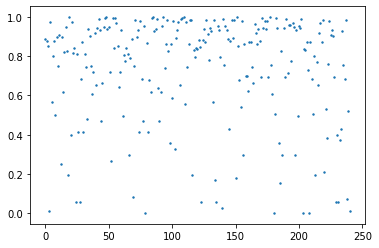

In [110]:
plt.scatter(df_order.index, df_order.sentiment, s = 2)

In [111]:
df_order.head()

,sort_name,df_min,df_max,appearances,review,name,address,pro_score,sentiment
0,,0,1,2,Adrienne’s Pizza Bar serves large pies on Ston...,adriennes pizza bar,"54 Stone St, New York, NY 10004",0.144718,0.887087
1,,2,2,1,Alligator Lounge is a divey sports bar in Will...,alligator lounge,,0.000000,0.876896
2,,3,3,1,If you love ample amounts of rich sauce and oi...,amore pizzeria,,0.564399,0.849441
3,,4,4,1,This Astoria restaurant is named as an homage ...,antika,,0.549928,0.012291
4,,5,7,3,An old newspaper article pinned beside the doo...,antonios,"32 Court St, Brooklyn, NY 11201, USA",0.308731,0.973098


In [112]:
df_order.sort_values('sentiment', ascending = False).head()

,sort_name,df_min,df_max,appearances,review,name,address,pro_score,sentiment
151,,297,308,12,When it comes to cool spaces to eat pizzas top...,paulie gees,500 Bay St.,0.377352,1.000000
48,,69,79,11,What is there to left say to about Di Fara? F...,di fara,1424 Avenue J.,0.334167,0.999815
19,,27,33,7,Best Pizza is a Williamsburg take on a classi...,best pizza,33 Havemeyer St,0.382468,0.998339
93,,172,182,11,"When someone talks about an ""L&B–style slice,""...",l & b spumoni gardens,"2725 86th St (at W 10th St), Brooklyn, NY",0.405473,0.998154
109,,209,218,10,"Old Brooklyn is harder to find these days, but...",lucali,"575 Henry St (btwn Carroll St & 1st Pl), Brook...",0.363676,0.997786


In [ ]:
df_order.to_csv('csv/pro reviews with scores.csv')

In [113]:
df_cleaned = pd.read_csv('csv/cleaned location data.csv', index_col = 0)

In [114]:
df_order.name = df_cleaned.name
df_order.address = df_cleaned.address
df_order['lat'] = df_cleaned.lat
df_order['long'] = df_cleaned.long
df_order['g_rating'] = df_cleaned.g_rating

In [115]:
df_order.appearances.max()

12

In [116]:
df_appearance_score = pd.read_csv('csv/appearance score.csv', index_col = 0)

In [117]:
df_appearance_score

,reviews,inclusion,exclusion,inclusion_score,exclusion_score,total_score,scaled_score
0,1,1.624518,0.000000,1.624518,0.000000,1.624518e+00,0.435245
1,2,1.601546,0.832555,3.226063,0.832555,2.393509e+00,0.641275
2,3,1.576359,1.048147,4.802422,1.880702,2.921720e+00,0.782795
3,4,1.548514,1.177410,6.350936,3.058112,3.292824e+00,0.882222
4,5,1.517427,1.268636,7.868363,4.326748,3.541615e+00,0.948879
5,6,1.482304,1.338566,9.350667,5.665314,3.685353e+00,0.987389
6,7,1.442027,1.394959,10.792694,7.060273,3.732421e+00,1.000000
7,8,1.394959,1.442027,12.187653,8.502300,3.685353e+00,0.987389
8,9,1.338566,1.482304,13.526219,9.984604,3.541615e+00,0.948879
9,10,1.268636,1.517427,14.794855,11.502031,3.292824e+00,0.882222


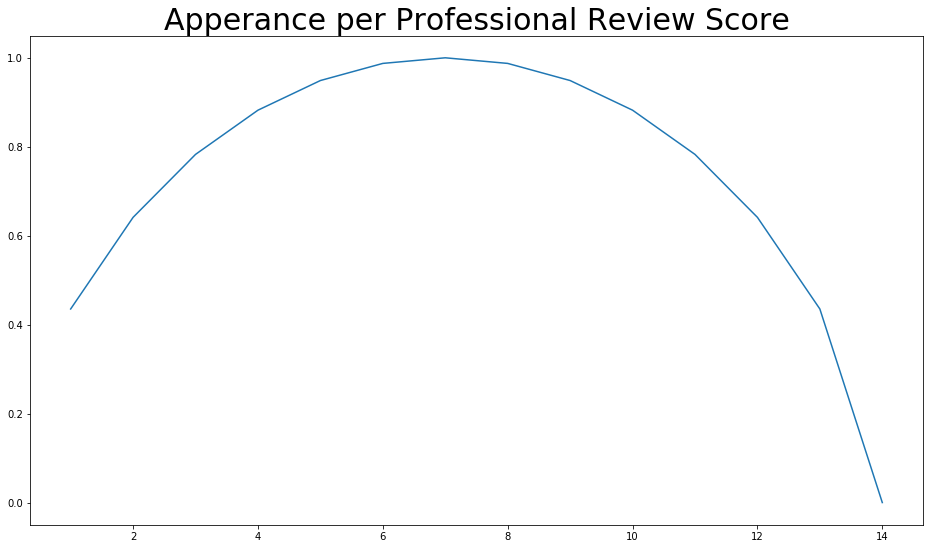

In [121]:
plt.figure(figsize = (16,9))
plt.title('Apperance per Professional Review Score', fontsize = 30)
plt.plot(df_appearance_score.index + 1, df_appearance_score.scaled_score)

In [122]:
appearance_scores = [None] * len(df_order)

for i in range(len(df_order.appearances)):
    for j in range(len(df_appearance_score.scaled_score)):
        if df_order.appearances[i] == df_appearance_score.reviews[j]:
            appearance_scores[i] = df_appearance_score.scaled_score[j]

In [123]:
df_order['appearance_scores'] = appearance_scores

In [126]:
df_order.head(3)

,sort_name,df_min,df_max,appearances,review,name,address,pro_score,sentiment,lat,long,g_rating,appearance_scores
0,,0,1,2,Adrienne’s Pizza Bar serves large pies on Ston...,Adrienne's Pizzabar,"54 Stone St, New York, NY 10004, USA",0.144718,0.887087,40.704294,-73.888473,4.4,0.641275
1,,2,2,1,Alligator Lounge is a divey sports bar in Will...,Alligator Lounge,"600 Metropolitan Ave, Brooklyn, NY 11211, USA",0.000000,0.876896,40.713984,-73.888473,4.3,0.435245
2,,3,3,1,If you love ample amounts of rich sauce and oi...,Cafe Amore's Restaurant,"147 Chambers St, New York, NY 10007, USA",0.564399,0.849441,40.715978,-73.888473,3.3,0.435245


In [127]:
df_order.name[148] = "Patricia's"
df_order.address[148] = "1082 Morris Park Ave, The Bronx, NY 10461"
df_order.g_rating[148] = 4.4
df_order.lat[148] = 40.849351
df_order.long[148] = -73.853481

/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing 

In [128]:
df_order.name[151] = "Paulie Gee's"
df_order.address[151] = "60 Greenpoint Ave, Brooklyn, NY 11222"
df_order.g_rating[151] = 4.6
df_order.lat[151] = 40.729782
df_order.long[151] = -73.958616

/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing 

In [129]:
df_pro_draft = df_order[['name', 'address', 'pro_score', 'sentiment', 'g_rating', 'appearance_scores', 'lat', 'long']]

In [130]:
df_testing = df_pro_draft.copy()

In [164]:
P, S, G, A = 6, 5, 1, 5

In [163]:
df_testing.describe()

,pro_score,sentiment,g_rating,appearance_scores,lat,long,score_3
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,0.282159,0.731075,4.349378,0.541206,40.720099,-73.891051,12.121575
std,0.143483,0.276804,0.269741,0.172650,0.064190,0.019228,2.095636
min,0.000000,0.000000,3.000000,0.435245,40.541357,-74.122162,7.058102
25%,0.205499,0.616764,4.200000,0.435245,40.683608,-73.888473,10.707623
50%,0.332851,0.840364,4.400000,0.435245,40.721078,-73.888473,11.942299
75%,0.332851,0.940997,4.500000,0.641275,40.753119,-73.888473,13.235257
max,0.824891,1.000000,5.000000,1.000000,40.918790,-73.853481,16.761137


In [ ]:
df_testing['score_1'] = (df_testing['pro_score'] * P) + (df_testing['sentiment'] * S) + (df_testing['g_rating'] * G) + (df_testing['appearance_scores'] * A)

In [ ]:
df_testing['score_2'] = (df_testing['pro_score'] * P) + (df_testing['sentiment'] * S) + (df_testing['g_rating'] * G) + (df_testing['appearance_scores'] * A)

In [165]:
df_testing['score_3'] = (df_testing['pro_score'] * P) + (df_testing['sentiment'] * S) + (df_testing['g_rating'] * G) + (df_testing['appearance_scores'] * A)

In [166]:
df_testing.sort_values('score_3', ascending = False).reset_index(drop=True).name

0                                  Pasquale Jones
1                                        Rubirosa
2                         Emmy Squared - Brooklyn
3                             Prince Street Pizza
4                               Motorino Pizzeria
5                                      Best Pizza
6                               Denino's Pizzeria
7                                             Ops
8                                     Joe & Pat's
9                              Williamsburg Pizza
10                               Patsy's Pizzeria
11                                   Speedy Romeo
12                                   Lee's Tavern
13                                    Joe's Pizza
14                             Kesté Pizza & Vino
15                               Emily - Brooklyn
16                          Louie & Ernie's Pizza
17                                         Lucali
18                                        Louie's
19                                      Sottocasa


In [167]:
df_testing.sort_values('score_3', ascending = False).reset_index(drop = True)

,name,address,pro_score,sentiment,g_rating,appearance_scores,lat,long,score_3
0,Pasquale Jones,"187 Mulberry St, New York, NY 10012, USA",0.608177,9.818286e-01,4.4,0.882222,40.721078,-73.888473,17.369313
1,Rubirosa,"235 Mulberry St, New York, NY 10012, USA",0.415754,9.918964e-01,4.6,1.000000,40.722753,-73.888473,17.054003
2,Emmy Squared - Brooklyn,"364 Grand St, Brooklyn, NY 11211, USA",0.409732,9.961269e-01,4.5,0.987389,40.712169,-73.888473,16.875975
3,Prince Street Pizza,"27 Prince St A, New York, NY 10012, USA",0.411963,9.953903e-01,4.6,0.948879,40.723084,-73.888473,16.793126
4,Motorino Pizzeria,"139 Broadway, Brooklyn, NY 11211, USA",0.397354,9.834714e-01,4.4,1.000000,40.710464,-73.888473,16.701479
5,Best Pizza,"33 Havemeyer St, Brooklyn, NY 11211, USA",0.382468,9.983389e-01,4.4,1.000000,40.715656,-73.888473,16.686505
6,Denino's Pizzeria,"524 Port Richmond Ave, Staten Island, NY 10302...",0.394211,9.942861e-01,4.6,0.948879,40.630159,-73.888473,16.681092
7,Ops,"346 Himrod St, Brooklyn, NY 11237, USA",0.448625,9.895106e-01,4.6,0.882222,40.702615,-73.888473,16.650415
8,Joe & Pat's,"1758 Victory Blvd, Staten Island, NY 10314",0.370116,9.955744e-01,4.3,0.987389,40.613109,-74.122162,16.435514
9,Williamsburg Pizza,"265 Union Ave, Brooklyn, NY 11211, USA",0.395080,9.849332e-01,4.2,0.987389,40.708104,-73.888473,16.432091


In [136]:
df_pro_draft.sort_values('appearance_scores', ascending = False).

,name,address,pro_score,sentiment,g_rating,appearance_scores,lat,long
0,Motorino Pizzeria,"139 Broadway, Brooklyn, NY 11211, USA",0.397354,9.834714e-01,4.4,1.000000,40.710464,-73.888473
1,Rubirosa,"235 Mulberry St, New York, NY 10012, USA",0.415754,9.918964e-01,4.6,1.000000,40.722753,-73.888473
2,Best Pizza,"33 Havemeyer St, Brooklyn, NY 11211, USA",0.382468,9.983389e-01,4.4,1.000000,40.715656,-73.888473
3,Emmy Squared - Brooklyn,"364 Grand St, Brooklyn, NY 11211, USA",0.409732,9.961269e-01,4.5,0.987389,40.712169,-73.888473
4,Williamsburg Pizza,"265 Union Ave, Brooklyn, NY 11211, USA",0.395080,9.849332e-01,4.2,0.987389,40.708104,-73.888473
5,Kesté Pizza & Vino,"271 Bleecker St, New York, NY 10014, USA",0.317656,9.887772e-01,4.5,0.987389,40.731534,-73.888473
6,Joe & Pat's,"1758 Victory Blvd, Staten Island, NY 10314",0.370116,9.955744e-01,4.3,0.987389,40.613109,-74.122162
7,Joe's Pizza,"7 Carmine St, New York, NY 10014, USA",0.343464,9.970482e-01,4.5,0.948879,40.730588,-73.888473
8,Prince Street Pizza,"27 Prince St A, New York, NY 10012, USA",0.411963,9.953903e-01,4.6,0.948879,40.723084,-73.888473
9,Mama's TOO!,"2750 Broadway, New York, NY 10025, USA",0.297829,9.842021e-01,4.4,0.948879,40.800832,-73.888473


In [ ]:
df_pro_draft.to_csv('csv/pro review scores output.csv')